In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [2]:
results = pd.read_csv("test_results/pg_duck_tpch_scaling_test_results.csv") 
test_name = "postgres_duck_db_scaling"

results = results.rename(columns={"Average": "Mean"})

In [3]:
#print(len(results))
#results.head()

In [4]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

352


In [5]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def ignore_first_mean(runs):
    return g_mean(runs[1:])

results['Mean'] = results.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]

In [6]:
scaling_results = results \
    .groupby(['Scaling Factor', 'Query Type'], sort=False, as_index=False) \
    .agg(
        mean_runtime=("Mean", g_mean),
    )

scaling_results = scaling_results.sort_values(by=["Scaling Factor", "Query Type"])

In [7]:
# Make the numbers relative
mean_dict = scaling_results[scaling_results["Scaling Factor"] == 0.5][["Query Type", "mean_runtime"]].reset_index(drop=True).set_index(["Query Type"]).to_dict('index')

def do_scaling(q_type, mean_runtime):
    return float(mean_runtime / mean_dict[q_type]['mean_runtime'])

scaling_results['Scaled Runtime'] = scaling_results.apply(lambda row : do_scaling(row['Query Type'], row["mean_runtime"]), axis = 1)

In [8]:
scaling_results

,Scaling Factor,Query Type,mean_runtime,Scaled Runtime
13,0.5,Duck DB,0.102788,1.000000
14,0.5,Pandas Converted (Duck DB),0.362977,1.000000
15,0.5,Pandas Converted (Postgres),0.445983,1.000000
0,0.5,Postgres,0.650782,1.000000
7,1.0,Duck DB,0.214884,2.090560
12,1.0,Pandas Converted (Duck DB),0.744483,2.051048
2,1.0,Pandas Converted (Postgres),0.937648,2.102431
1,1.0,Postgres,1.432750,2.201582
4,2.0,Duck DB,0.456099,4.437291
5,2.0,Pandas Converted (Duck DB),1.620265,4.463824


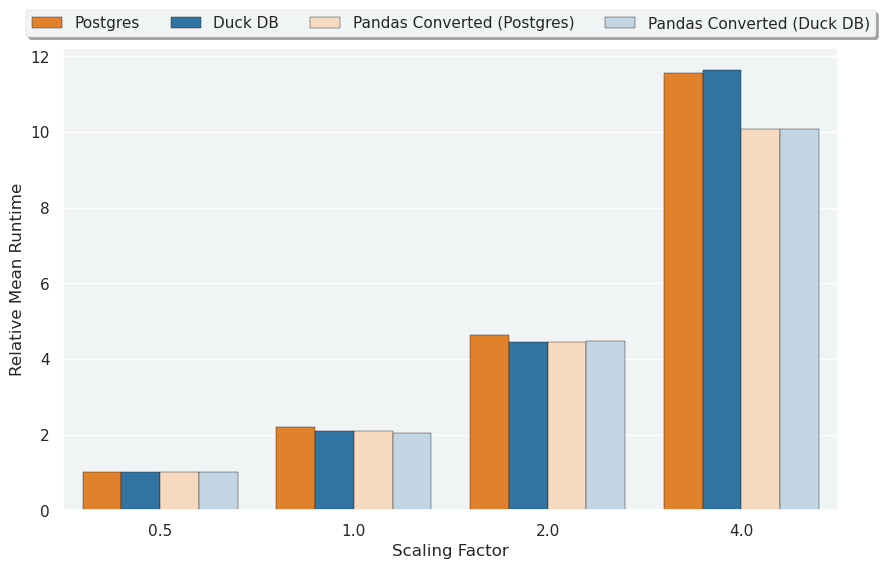

In [9]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

color = ['tab:orange','tab:blue','#ffd9b7', '#bcd6e9']
order = ["Postgres", "Duck DB", "Pandas Converted (Postgres)", "Pandas Converted (Duck DB)"]

ax = sns.barplot(data=scaling_results, x='Scaling Factor', y='Scaled Runtime', hue='Query Type',
                 palette=color, hue_order=order)

ax.set(xlabel='Scaling Factor', ylabel='Relative Mean Runtime')
# ax.set_yscale("log")

# # the non-logarithmic labels 
# ticks = [1, 10]
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticks)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
           ncol=4, fancybox=True, shadow=True)

plt.savefig("analysis_results/" + str(test_name) + "_queries.pdf", bbox_inches="tight")
plt.show()

### Focus on specific cells

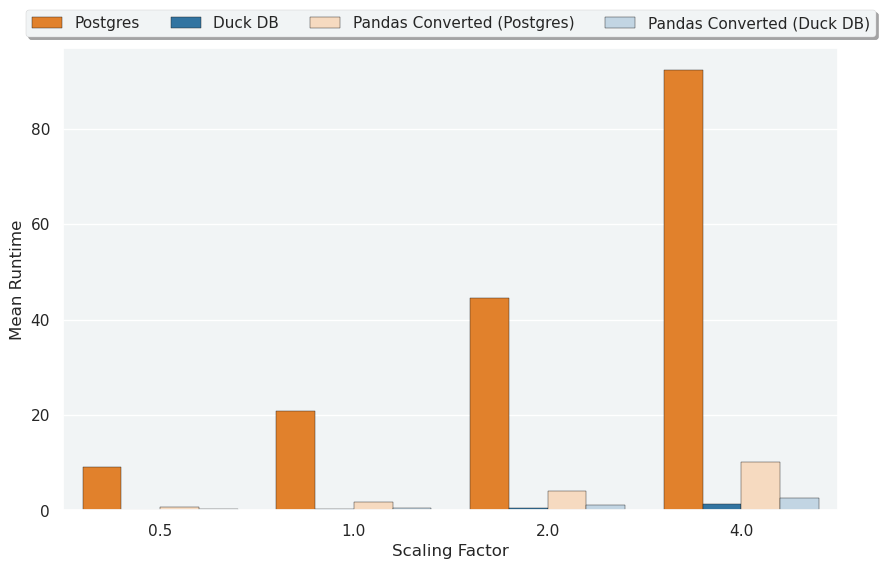

In [10]:
q20_results = results[results["Query Number"] == 20].sort_values(by=["Scaling Factor", "Query Type"])

# plot with seaborn barplot
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

color = ['tab:orange','tab:blue','#ffd9b7', '#bcd6e9']
order = ["Postgres", "Duck DB", "Pandas Converted (Postgres)", "Pandas Converted (Duck DB)"]

ax = sns.barplot(data=q20_results, x='Scaling Factor', y='Mean', hue='Query Type',
                 palette=color, hue_order=order)

ax.set(xlabel='Scaling Factor', ylabel='Mean Runtime')
# ax.set_yscale("log")

# # the non-logarithmic labels 
# ticks = [1, 10]
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticks)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
           ncol=4, fancybox=True, shadow=True)

#plt.savefig("analysis_results/" + str(test_name) + "_queries.pdf", bbox_inches="tight")
plt.show()